In [1]:
# Modules
import numpy as np
import matplotlib.pyplot as plt
import math
import os


# Constants
SCREEN_SIZE = 64
BAR_WIDTH = 10
ORIENTATIONS = np.deg2rad([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5])  # Convert to radians
STIMULI_DURATION = 500  # duration of each stimulus in ms


# import of Files
def read_data(cell_number):
    """Load spike times for a given cell number."""
    with open(os.path.join('Data', f'Cell{cell_number}.txt'), 'r') as f:
        return [int(line) for line in f]

# Neuroscience and Data Science

### Problem 1

In an experiment, visual stimuli in form of moving light bars are presented on a 64x64 pixel screen
with the origin at the center. They move perpendicular to their orientation φ, which cycles through
the sequence [0; 22.5; 45; 67.5; 90; 112.5; 135; 157.5]. Each moving bar is shown for 500 ms until the
stimulation switches to the next orientation. During that time, the center of the bar always moves
64 2 pixels (whole length of the diagonal) with the origin always being passed after 250 ms. Thus, at 
time t (in ms) the distance from the origin is given by

$d(t)=64 \sqrt{2} \cdot\left(\frac{t \bmod 500}{500}-\frac{1}{2}\right)$

With the light bars having a width of 10 pixels, the set of illuminated pixels is:

$\{(x, y) \| \cos (\phi) x+\sin (\phi) y-d(t) \mid<10 / 2\}$

wheras the rest of the pixels remained dark

(a) Input generator Implement a function that returns the stimulus (matrix) for any given time. Plot the visual stimulus at 22.2 s and 33.3 s after the experiment has started.
Tip: Python sine and cosine functions do not operate in degrees but radians.

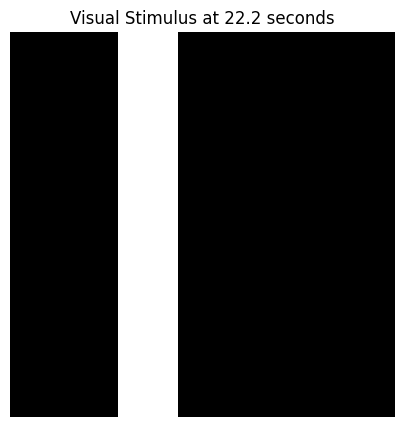

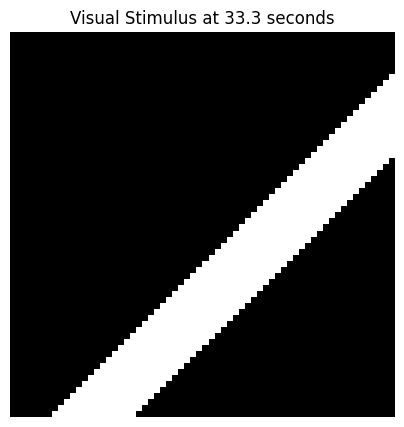

In [2]:
def d(t):
    """Calculate the distance from origin at time t."""
    return 64 * np.sqrt(2) * ((t % 500) / 500 - 1/2)

def stimulus(t):
    """Generate the visual stimulus matrix at time t."""
    
    # Calculate the bar orientation index based on time
    orientation_index = int(t // 500) % len(ORIENTATIONS)
    phi = ORIENTATIONS[orientation_index]

    # Initialize the stimulus matrix as dark
    stimulus_matrix = np.zeros((SCREEN_SIZE, SCREEN_SIZE))

    # Calculate the current distance from origin
    distance = d(t)

    # Coordinates for the center of the screen
    x0, y0 = SCREEN_SIZE // 2, SCREEN_SIZE // 2

    # Set pixels to illuminated if they fall within the bar
    for i in range(SCREEN_SIZE):
        for j in range(SCREEN_SIZE):
            x = i - x0
            y = j - y0
            if np.abs(np.cos(phi) * x + np.sin(phi) * y - distance) < BAR_WIDTH / 2:
                stimulus_matrix[i, j] = 1
    
    return stimulus_matrix

def plot_stimulus(t):
    """Plot the visual stimulus matrix at time t."""
    plt.figure(figsize=(5, 5))
    plt.imshow(stimulus(t), cmap='gray')
    plt.title('Visual Stimulus at {} seconds'.format(t / 1000))
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.axis('off')
    plt.show()

# Convert time from seconds to milliseconds
plot_stimulus(22.2 * 1000)
plot_stimulus(33.3 * 1000)



(b) Data inspection: Download the data files (”Cell0.txt” ... ”Cell7.txt” in Data.zip) from StudIP. Each file contains the spike times (in milliseconds) of one neuron during the same experiment following the above description.
For cell 0, make a raster-plot, where the x-axis marks the time since the bar with the current orientation is shown (time during trial). In the y-axis, all trials with the same orientation should be adjacent and these groups should be ordered according to the bar orientation.

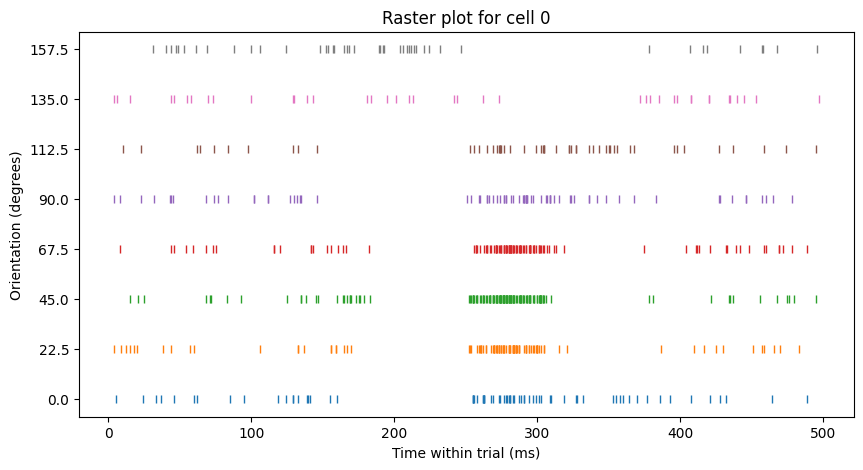

In [3]:
def plot_raster(cell_number):
    """Create a raster plot for a given cell number."""
    # Load spike times
    spike_times = read_data(cell_number)

    # Initialize a list of lists to hold spike times for each trial
    trials = [[] for _ in range(len(ORIENTATIONS))]

    # Assign spike times to trials
    for spike_time in spike_times:
        # Calculate trial number and time within trial
        trial = int(spike_time // 500) % len(ORIENTATIONS)
        time_within_trial = spike_time % 500

        # Append time within trial to appropriate trial list
        trials[trial].append(time_within_trial)

    # Create raster plot
    plt.figure(figsize=(10, 5))
    for i, trial in enumerate(trials):
        plt.plot(trial, [i]*len(trial), '|', label='Orientation {:.1f}'.format(ORIENTATIONS[i] * 180 / np.pi))
    plt.yticks(range(len(ORIENTATIONS)), labels=np.rad2deg(ORIENTATIONS))
    plt.xlabel('Time within trial (ms)')
    plt.ylabel('Orientation (degrees)')
    plt.title(f'Raster plot for cell {cell_number}')
    plt.show()

# Plot raster plot for cell 0
plot_raster(0)



(c) Receptive fields: Use the spike-triggered average to calculate the receptive fields for all cells: 

$S T A(x, y)=\frac{1}{\# \text { of spikes }} \sum_t I(x, y, t) s(t)$

where I(x, y, t) is the stimulus image and s(t) a binary variable that indicates whether the neuron has spiked at time t. Plot the receptive fields (Use color coded 2D plots e.g., pcolor/imshow in python).
Tip: The results become more interpretable if the input stimuli have zero mean. Hence, it may help to subtract the mean stimulation from your STA.


/var/folders/9d/zlrv9fwj03j3mm7_f9snfms40000gn/T/ipykernel_20300/3112399243.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # adjust the layout to make room for the colorbar


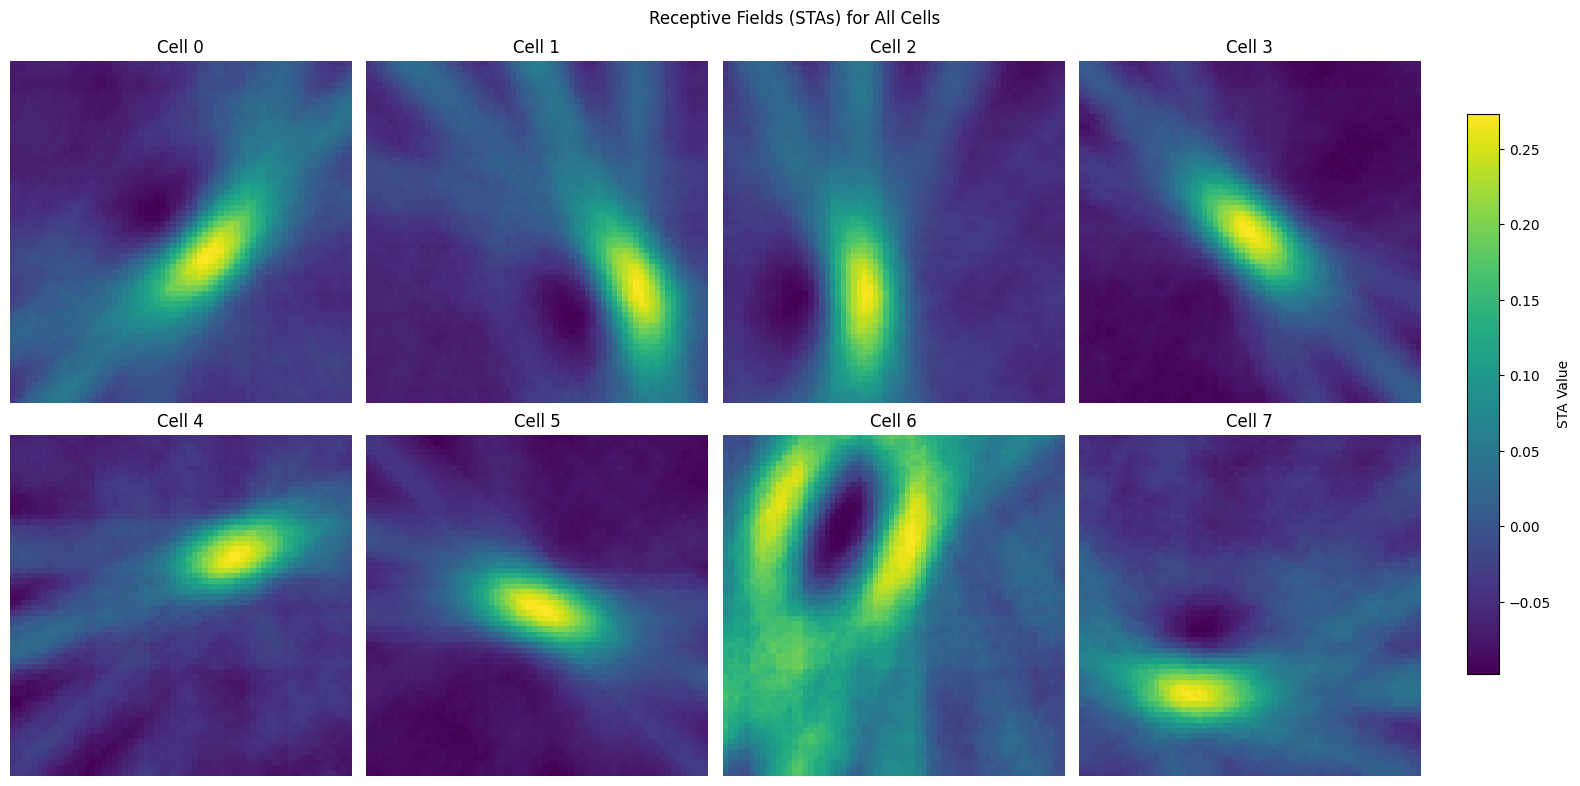

In [4]:
def calculate_sta(data):
    """Calculate the spike-triggered average (STA) for a given cell."""
    total_stimulus = np.zeros((SCREEN_SIZE, SCREEN_SIZE))
    num_spikes = len(data)

    for spike_time in data:
        total_stimulus += stimulus(spike_time)
    
    sta = total_stimulus / num_spikes
    mean_stimulation = np.mean(sta)
    
    return sta - mean_stimulation

def plot_sta(data, cell_number, ax):
    """Plot the spike-triggered average (STA) for a given cell on given axes."""
    sta = calculate_sta(data)

    im = ax.imshow(sta, cmap='viridis')
    ax.set_title('Cell {}'.format(cell_number))
    ax.axis('off')
    return im  # return the imshow object for colorbar

# Read data for each cell and plot their STAs
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # create a grid of 2 rows and 4 columns
ims = []  # list to store imshow objects

for i in range(8):
    data = read_data(f'{i}')
    row = i // 4  # calculate row index
    col = i % 4   # calculate column index
    ims.append(plot_sta(data, i, axs[row, col]))

# Add a colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[-1], cax=cbar_ax, orientation='vertical', label='STA Value')

plt.suptitle('Receptive Fields (STAs) for All Cells')
plt.tight_layout(rect=[0, 0, 0.9, 1])  # adjust the layout to make room for the colorbar
plt.show()


(d) Conditional firing rates: For each cell, evaluate and plot the time-dependent average firing rate for each stimulus (using 25 ms bins).

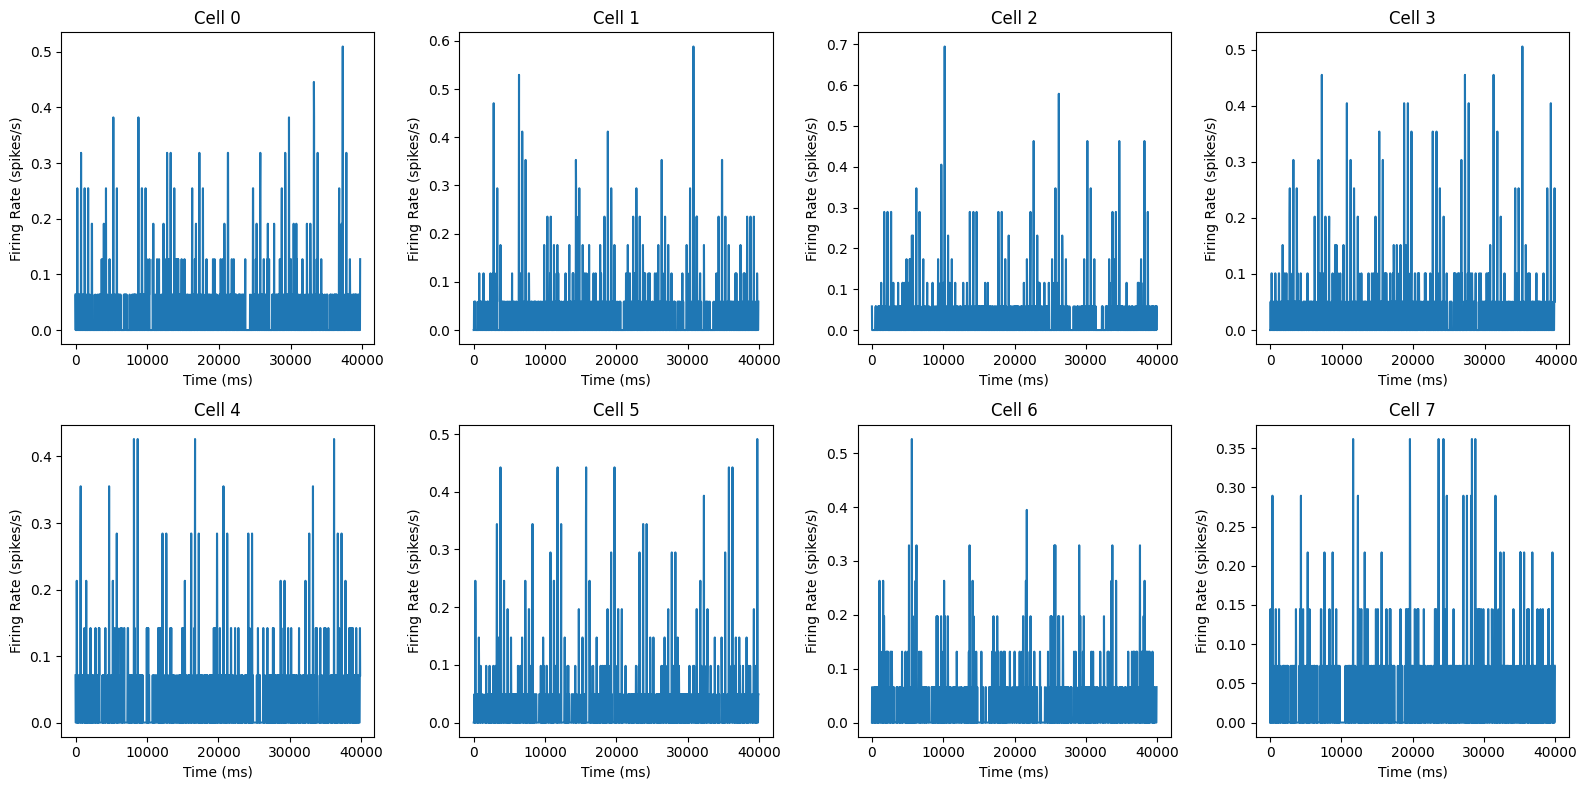

In [5]:
BIN_SIZE = 25  # size of each bin in ms

def calculate_firing_rates(data):
    """Calculate the firing rate for each stimulus."""
    max_time = max(data)
    bins = np.arange(0, max_time + BIN_SIZE, BIN_SIZE)
    counts, _ = np.histogram(data, bins=bins)
    
    return counts / (len(data) * BIN_SIZE) * 1000  # convert count to rate (spikes/s)

def plot_firing_rates(data, cell_number, ax):
    """Plot the firing rate for a given cell on given axes."""
    firing_rates = calculate_firing_rates(data)
    time_bins = np.arange(0, len(firing_rates) * BIN_SIZE, BIN_SIZE)
    
    ax.plot(time_bins, firing_rates)
    ax.set_title('Cell {}'.format(cell_number))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (spikes/s)')

# Read data for each cell and plot their firing rates
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # create a grid of 2 rows and 4 columns

for i in range(8):
    data = read_data(f'{i}')
    row = i // 4  # calculate row index
    col = i % 4   # calculate column index
    plot_firing_rates(data, i, axs[row, col])

plt.tight_layout()
plt.show()


(e) Tuning curves: For each cell, plot a tuning curve that shows how the firing rate changes with the presented stimulus. For each stimulus, use the maximal average firing rate of all 25 ms bins. Plot the tuning curve. Report the orientation φ to which the cells are tuned.

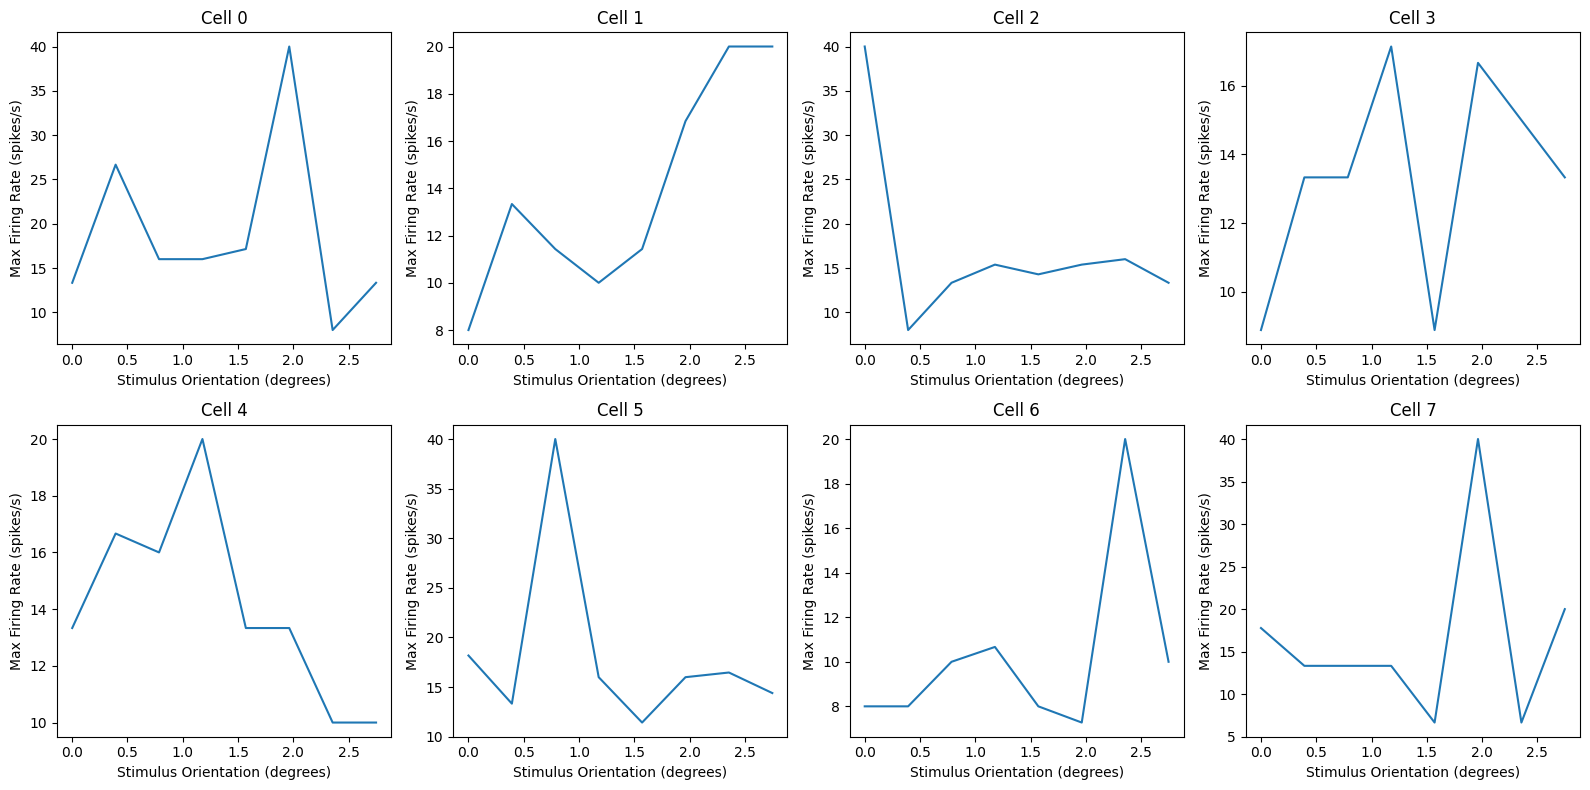

In [6]:
def calculate_max_firing_rates(data):
    """Calculate the maximum firing rate for each stimulus."""
    firing_rates = []
    
    for i in range(len(ORIENTATIONS)):
        stimulus_start_time = i * STIMULI_DURATION
        stimulus_end_time = (i + 1) * STIMULI_DURATION
        stimulus_data = [t for t in data if stimulus_start_time <= t < stimulus_end_time]
        firing_rate = calculate_firing_rates(stimulus_data)
        firing_rates.append(np.max(firing_rate))
    
    return firing_rates

def plot_tuning_curve(data, cell_number, ax):
    """Plot the tuning curve for a given cell on given axes."""
    max_firing_rates = calculate_max_firing_rates(data)
    
    ax.plot(ORIENTATIONS, max_firing_rates)
    ax.set_title('Cell {}'.format(cell_number))
    ax.set_xlabel('Stimulus Orientation (degrees)')
    ax.set_ylabel('Max Firing Rate (spikes/s)')

# Read data for each cell and plot their tuning curves
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # create a grid of 2 rows and 4 columns

for i in range(8):
    data = read_data(f'{i}')
    row = i // 4  # calculate row index
    col = i % 4   # calculate column index
    plot_tuning_curve(data, i, axs[row, col])

plt.tight_layout()
plt.show()


(f) Population vector decoding Decode the angle of the currently shown stimulus using the population vector method. Note, this method can only applied if the vectors point into all different directions in 2D space. Therefore, to also incorporate the periodicity of the tuning-curves, instead of using cell i’s the preferred orientation φi ∈ [0, 180], use 2φi ∈ [0, 360]. Every spike cell i fires while a stimulus is presented should increase the population vector by

$\vec{e}_i=\left(\cos \left(2 \phi_i\right), \sin \left(2 \phi_i\right)\right)^T$

After summing the contributions of all spikes and neurons up, use the (two-argument) arctan- function, divide by 2 to get back to our original preferred orientations and bring the result to the desired range of [-10,170] degree. Report the output of the first 10 stimuli.


In [7]:
def decode_stimulus_orientation(population_vector):
    """Decode the stimulus orientation from the given population vector."""
    angle = math.atan2(population_vector[1], population_vector[0])  # calculate the angle
    angle = angle / 2  # divide by 2 to get back to original preferred orientations
    angle = np.rad2deg(angle)  # convert to degrees
    angle = (angle + 360) % 180  # bring the result to the desired range of [0, 180] degrees
    return angle

def calculate_population_vectors(data):
    """Calculate the population vectors for the first 10 stimuli."""
    population_vectors = []
    
    for j in range(10):  # for each of the first 10 stimuli
        stimulus_start_time = j * STIMULI_DURATION
        stimulus_end_time = (j + 1) * STIMULI_DURATION
        population_vector = np.zeros(2)  # initialize population vector for this stimulus

        # For each cell, calculate the contribution to the population vector for this stimulus
        for i in range(len(data)):
            cell_data = data[i]
            stimulus_data = [t for t in cell_data if stimulus_start_time <= t < stimulus_end_time]
            for t in stimulus_data:
                # Double the preferred orientation to account for periodicity
                angle = 2 * ORIENTATIONS[i]
                contribution = np.array([math.cos(angle), math.sin(angle)])  # contribution of this cell
                population_vector += contribution  # add the contribution to the population vector
        
        population_vectors.append(population_vector)
    
    return population_vectors

# Read data for each cell
data = [read_data(f'{i}') for i in range(8)]

# Calculate the population vectors for the first 10 stimuli
population_vectors = calculate_population_vectors(data)

# Decode the stimulus orientation for the first 10 stimuli
decoded_orientations = [decode_stimulus_orientation(v) for v in population_vectors]

# Print the decoded orientations
for i, orientation in enumerate(decoded_orientations):
    print('Stimulus {}: Decoded Orientation = {:.2f} degrees'.format(i + 1, orientation))


Stimulus 1: Decoded Orientation = 130.71 degrees
Stimulus 2: Decoded Orientation = 101.25 degrees
Stimulus 3: Decoded Orientation = 164.04 degrees
Stimulus 4: Decoded Orientation = 7.32 degrees
Stimulus 5: Decoded Orientation = 50.19 degrees
Stimulus 6: Decoded Orientation = 49.16 degrees
Stimulus 7: Decoded Orientation = 80.59 degrees
Stimulus 8: Decoded Orientation = 96.36 degrees
Stimulus 9: Decoded Orientation = 170.75 degrees
Stimulus 10: Decoded Orientation = 97.77 degrees
